In [59]:
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
from torch.utils.data import random_split,Dataset,DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import time

from google.colab import drive

In [43]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
dataset = ImageFolder('/content/drive/MyDrive/praca_inzynierska/data/images_original/')

In [45]:
len(dataset)

1009

In [46]:
genres = []
for i in dataset.classes:
  genres.append(i)
genres

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [47]:
random_seed = 42
torch.manual_seed(random_seed);

In [48]:
test_pct = 0.2
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(len(dataset)*val_pct)
train_size = dataset_size - val_size
train_size,test_size,val_size

(708, 201, 100)

In [49]:
train_ds,test_ds,val_ds = random_split(dataset,[train_size,test_size,val_size])
len(train_ds),len(test_ds),len(val_ds)

(708, 201, 100)

jazz
<class 'PIL.Image.Image'>


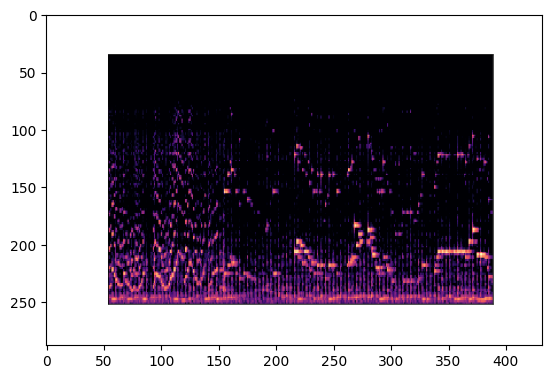

In [50]:
img,label = train_ds[2]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In [51]:
class MusicGenreDataset(Dataset):
  def __init__(self,ds,transform=None):
    self.ds = ds
    self.transform = transform

  def __len__(self):
    return len(self.ds)

  def __getitem__(self,idx):
    img,label = self.ds[idx]
    if self.transform:
      img = self.transform(img)
      return img,label

In [52]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomCrop(224, padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.GaussianBlur(kernel_size = 7,sigma = (0.1, 2.0)),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224,224))
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [53]:
train_dataset = MusicGenreDataset(train_ds,train_transform)
val_dataset = MusicGenreDataset(val_ds,val_transform)
test_dataset = MusicGenreDataset(test_ds,test_transform)

5


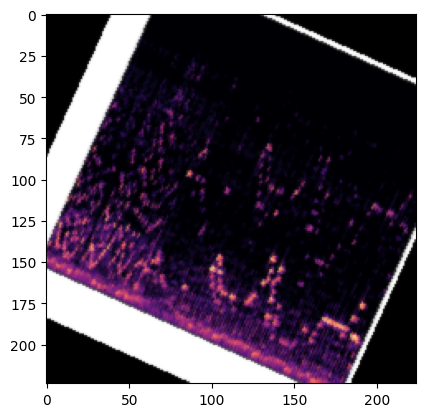

In [54]:
img, label = train_dataset[2]
print(label)
plt.imshow(img.permute(1,2,0))

In [58]:
batch_size = 20
train_dl = DataLoader(train_dataset,batch_size,shuffle=True,num_workers=2,pin_memory=True)
test_dl = DataLoader(test_dataset,batch_size*2,num_workers=2,pin_memory=True)
val_dl = DataLoader(val_dataset,batch_size*2,num_workers=2,pin_memory=True)

In [55]:
def proc_time(b_sz, model, n_iter=10):
    x = torch.rand(b_sz, 3, 224, 224).cuda()
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(n_iter):
        model(x)
    torch.cuda.synchronize()
    end = time.time() - start
    throughput = b_sz * n_iter / end
    print(f"Batch: {b_sz} \t {throughput} samples/sec")
    return (b_sz, throughput, )